## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5] #  factor: factor by which the learning rate will be reduced. new_lr = lr * factor
redice_lr_patient = [5,10]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 4s 72us/step - loss: 1.5795 - acc: 0.4504 - val_loss: 1.6769 - val_acc: 0.4141
Epoch 12/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.5593 - acc: 0.4591 - val_loss: 1.6618 - val_acc: 0.4217
Epoch 13/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5413 - acc: 0.4640 - val_loss: 1.6509 - val_acc: 0.4246
Epoch 14/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5245 - acc: 0.4708 - val_loss: 1.6428 - val_acc: 0.4278
Epoch 15/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.5092 - acc: 0.4749 - val_loss: 1.6338 - val_acc: 0.4285
Epoch 16/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.4947 - acc: 0.4803 - val_loss: 1.6240 - val_acc: 0.4326
Epoch 17/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.4813 - acc: 0.4854 - val_loss: 1.6137 - val_acc: 0.4370
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.5642 - acc: 0.1807 - val_loss: 2.3491 - val_acc: 0.2500
Epoch 2/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.0708 - acc: 0.2972 - val_loss: 2.0653 - val_acc: 0.3129
Epoch 3/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.9074 - acc: 0.3428 - val_loss: 1.9501 - val_acc: 0.3388
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.8200 - acc: 0.3678 - val_loss: 1.8584 - val_acc: 0.3657
Epoch 5/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.7602 - acc: 0.3876 - val_loss: 1.8178 - val_acc: 0.3726
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.7148 - acc: 0.4029 - val_loss: 1.7732 - val_acc: 0.3868
Epoch 7/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6775 - acc: 0.4152 - val_loss: 1.7463 - val_acc

50000/50000 [==============================] - 3s 51us/step - loss: 0.5434 - acc: 0.8382 - val_loss: 1.4063 - val_acc: 0.5409
Epoch 24/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.5374 - acc: 0.8383 - val_loss: 1.4060 - val_acc: 0.5445
Epoch 25/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.5326 - acc: 0.8406 - val_loss: 1.4153 - val_acc: 0.5427
Numbers of exp: 5, reduce_factor: 0.20, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_laye

Epoch 11/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.1520 - acc: 0.6072 - val_loss: 1.4798 - val_acc: 0.4861
Epoch 12/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.1280 - acc: 0.6141 - val_loss: 1.4515 - val_acc: 0.4944
Epoch 13/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1038 - acc: 0.6241 - val_loss: 1.4460 - val_acc: 0.4891
Epoch 14/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.0815 - acc: 0.6338 - val_loss: 1.4182 - val_acc: 0.5037
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0611 - acc: 0.6427 - val_loss: 1.4308 - val_acc: 0.5009
Epoch 16/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0405 - acc: 0.6508 - val_loss: 1.4404 - val_acc: 0.4967
Epoch 17/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.0212 - acc: 0.6581 - val_loss: 1.4332 - val_acc: 0.4963
Epoch 18/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.8011 - acc: 0.3780 - val_loss: 3.2043 - val_acc: 0.2175
Epoch 2/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5356 - acc: 0.4548 - val_loss: 2.1773 - val_acc: 0.3151
Epoch 3/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.4281 - acc: 0.4939 - val_loss: 2.4242 - val_acc: 0.2780
Epoch 4/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.3508 - acc: 0.5199 - val_loss: 2.3892 - val_acc: 0.2707
Epoch 5/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2932 - acc: 0.5409 - val_loss: 1.8880 - val_acc: 0.3617
Epoch 6/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2369 - acc: 0.5607 - val_loss: 2.0681 - val_acc: 0.3058
Epoch 7/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1959 - acc: 0.5770 - val_loss: 1.8897 - val_acc

50000/50000 [==============================] - 3s 55us/step - loss: 0.6212 - acc: 0.8133 - val_loss: 1.4200 - val_acc: 0.5158
Epoch 24/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.5939 - acc: 0.8264 - val_loss: 1.4238 - val_acc: 0.5174
Epoch 25/25
50000/50000 [==============================] - 3s 54us/step - loss: 0.5803 - acc: 0.8309 - val_loss: 1.4248 - val_acc: 0.5238
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_laye

Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2902 - acc: 0.5523 - val_loss: 1.5254 - val_acc: 0.4621
Epoch 12/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2631 - acc: 0.5634 - val_loss: 1.5340 - val_acc: 0.4656
Epoch 13/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.2370 - acc: 0.5743 - val_loss: 1.5150 - val_acc: 0.4697
Epoch 14/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2105 - acc: 0.5836 - val_loss: 1.5025 - val_acc: 0.4671
Epoch 15/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.1892 - acc: 0.5912 - val_loss: 1.5024 - val_acc: 0.4728
Epoch 16/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1652 - acc: 0.6034 - val_loss: 1.5108 - val_acc: 0.4700
Epoch 17/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1422 - acc: 0.6105 - val_loss: 1.5037 - val_acc: 0.4714
Epoch 18/25
50000/50000 [=========

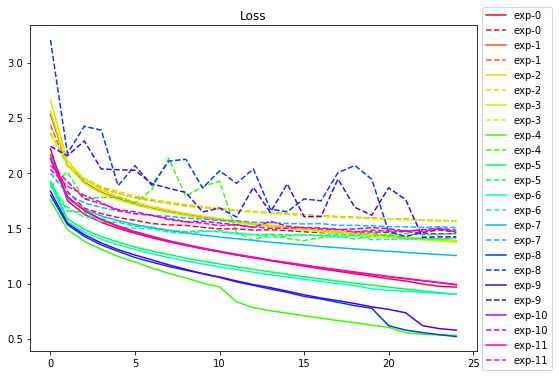

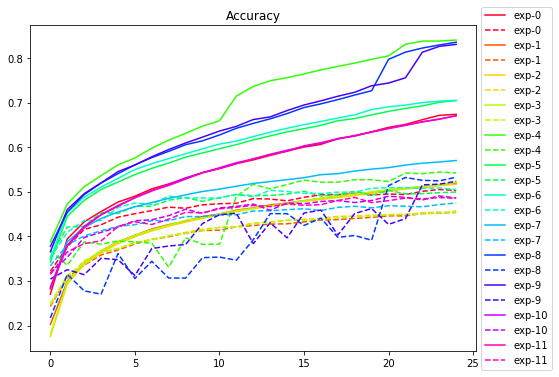

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()